#  Introduction to JAX

<a target="_blank" href="https://colab.research.google.com/github/instadeepai/tpu-workshop/blob/main/JaxIntroWorkshop.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Authors:**
Donal Byrne

**With Thanks:**
Kale-ab Tessera

<br/>

In this workshop we will walk through a crash course in JAX, going through everthing you need to know to start developing algorithms on Google Cloud TPU's🌩️!

### &#x1F440; **Contents**

* &#x1F6A7; [Setup](#scrollTo=uTgyaSXdXTV2&line=1&uniqifier=1)

* 🤔 [What Is JAX](#scrollTo=JGkHAequ08zr&line=1&uniqifier=1)

* 😀 [JAX Basics](#scrollTo=Q8dT4n8DebuP&line=1&uniqifier=1)

    * 🏍️ [Accelerated Numpy](#scrollTo=4ZM6E8Zl01Wf&line=1&uniqifier=1)

    * 🔒 [Immutability](#scrollTo=WM2fgptY1tYg&line=1&uniqifier=1)

    * 🎲 [Randomness](#scrollTo=VEwV_x1iAJ7_&line=1&uniqifier=1)

    * 🖥️ [Agnostic Backend](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

* 🤖 [JAX Transformations](#scrollTo=6qPm35e3eh2U&line=1&uniqifier=1)

    * [Jit](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Grad](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Vmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

    * [Pmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

* 📈 [Model Training](#scrollTo=kkdWuxuETlbE&line=7&uniqifier=1)

* 🔢[Coding Challenge](#scrollTo=Un0kkCZ0tEzK)

* 📚 [Further Reading?](#scrollTo=-mI2c8DjwS3n&line=6&uniqifier=1)


# Setup

In [1]:
# Make sure to use a version of chex compatible with jax 0.3.25
! pip install -U chex==0.1.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: chex
    Found existing installation: chex 0.1.7
    Uninstalling chex-0.1.7:
      Successfully uninstalled chex-0.1.7


In [2]:
## Install and import anything required. Capture hides the output from the cell.

import subprocess
import os

# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output('nvidia-smi')
    print("a GPU is connected.")
except Exception:
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
        import jax.tools.colab_tpu
        jax.tools.colab_tpu.setup_tpu()
        print("A TPU is connected.")

    else:
        print("Only CPU accelerator is connected.")
        # x8 cpu devices - number of (emulated) host devices
        os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
import optax
import matplotlib.pyplot as plt
import numpy as np

A TPU is connected.


In [3]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [4]:
# @title Check the device you are using (Run Cell)
print(f"Device Count: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Device Count: 8
 Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


# 🤔 What is JAX?

JAX is a **high performance**, numerical computing library which focuses on generating **optimized code**, as **simply** as possible.

By combining the best of NumPy, Autograd, and XLA (Accelerated Linear Algebra), JAX enables users to express complex algorithms while achieving very high performance.

JAX focuses on providing minimal, yet powerful, low level operations and transformations that empower user to easily develop and scale scientific based experiments.

To top it off, JAX automatically scales to all major Hardware Accelerators without the need for any code changes.


# JAX Basics


## Pure Functions

JAX provides powerful transformations to help accelerate your code, but in order to do this relaibaly, JAX has be designed to work with **pure functions**. These functions have the following properties:

1. All **input** data is passed through the **function's parameters**.
2. All **results** are output through the **function's return**.
3. The function always returns the same **result** if invoked with the **same inputs**. What if your function involves randomness? Pass in the [random seed](https://colab.research.google.com/drive/1aNeOACzDCquUsTKadeyvAWwYkGNY7pad?authuser=1#scrollTo=VEwV_x1iAJ7_&line=1&uniqifier=1)!
4. **No [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science))** - no mutation of non-local variables or input/output streams.


In [5]:
# Impure - Bad

global_term = 3
outputs = 0

def impure_function(x: int) -> None:
    outputs = x + global_term

# Pure - Good

def pure_function(x: int, term: int) -> int:
    return x + term

## Accelerated Numpy

JAX is frequently refered to as **Accelerated Numpy**.
The main similarity between JAX and NumPy is that they share a similar interface and often, JAX and NumPy arrays can be used interchangeably. Most methods in NumPy will have a jax counter part, making JAX easier to pick up if you are already familiar with Numpy.

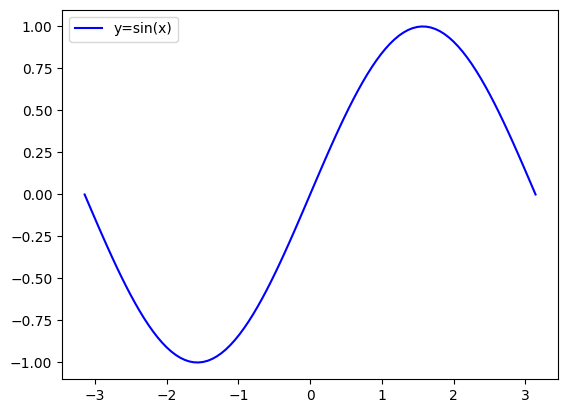

In [6]:
# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

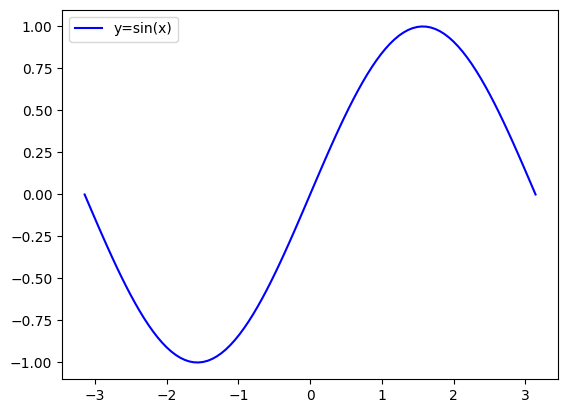

In [7]:
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

## Immutability

One of the key differences between Numpy and JAX is that Jax arrays are **immutable** (they can't be modified after they are created). Allowing mutations makes transforms difficult and violates conditions for [pure functions](https://en.wikipedia.org/wiki/Pure_function).

In [8]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [9]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

Exception '<class 'jax._src.device_array._DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [10]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

 new_x: [10  1  2  3  4  5  6  7  8  9] original x: [0 1 2 3 4 5 6 7 8 9]


## Randomness
Pseudo Random Number Generation (PRNG) is the process of algorithmically generating a sequence of numbers, which approximate the properties of a sequence of random numbers. JAX is more explicit in PRNG than NumPy and other libraries (such as TensorFlow or PyTorch) and uses a modern PRNG algorithm([Threefry counter-based PRNG](https://bashtage.github.io/randomgen/bit_generators/threefry.html)) that handles the random state explicitly.

Let's see the differences in how JAX and NumPy generate random numbers.

In [11]:
# Set random seed
np.random.seed(42)
prng_state = np.random.get_state()

In [12]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

In [13]:
# Example of PRNG in numpy, generate independent samples each time

print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

sample 1 = 0.4967141530112327 Did prng state change: True
sample 2 = -0.13826430117118466 Did prng state change: True
sample 3 = 0.6476885381006925 Did prng state change: True


In [14]:
# Example of PRNG in JAX, same key will always provide the same output
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

sample 1 = -0.18471184372901917
sample 2 = -0.18471184372901917
sample 3 = -0.18471184372901917


In [15]:
# Example of splitting our random key in order to generate independent
# samples with JAX

from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

sample 1 = -0.18471184372901917
sample 2 = 1.3694629669189453
sample 3 = -0.19947032630443573


##Agnostic Backend

Using JAX, you can run the same code on different backends/AI accelerators (e.g. CPU/GPU/TPU), with no changes in code (no more .to(device) - from frameworks like PyTorch). This means we can easily run linear algebra operations directly on GPU/TPU and easily scale to more complex and resource heavy experiments.

In [17]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

170 ms ± 44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()

The slowest run took 10.29 times longer than the fastest. This could mean that an intermediate result is being cached.
9.6 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


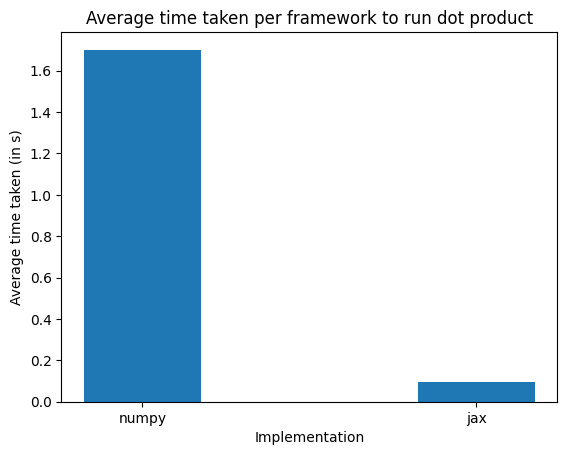

jax was 17.73 times faster than numpy !!!


In [19]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

# JAX Transformations

JAX transformations are functions that help modify and manipulate your normal python functions to execute them efficiently on hardware accelerators like TPUs.

##Jit Compiling

JIT compilers compile the code during execution, translating parts of the source code into machine code just before they are run.

This allows for optimizations tailored to the specific runtime context, such as function inlining, loop unrolling, or type specialization, and can lead to significant performance improvements.

Let's compile [ReLU (Rectified Linear Unit)](https://arxiv.org/abs/1803.08375), a popular activation function in deep learning.


ReLU is defined as follows:
<center>$f(x)=max(0,x)$</center>

It can be visualized as follows:

<center>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="35%" />
</center>,

where $x$ is the input to the function and $y$ is output of ReLU.

In [20]:
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached.
8.46 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.67 ms ± 617 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


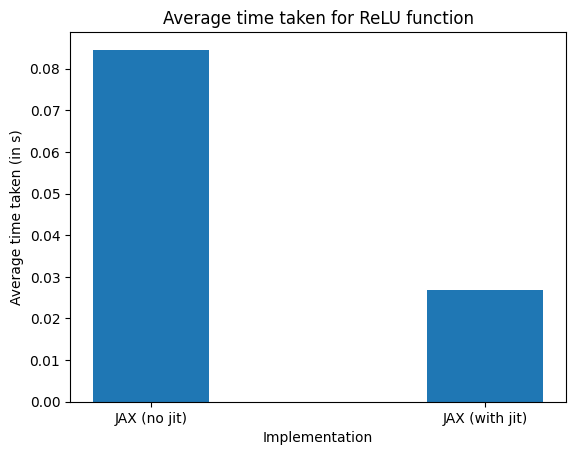

JAX (with jit) was 3.16 times faster than JAX (no jit) !!!


In [21]:
# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

##Grad

Grad allows us to easily calculate the gradients of a given function.

In [22]:
f = lambda x: 6 * x**4 - 9 * x + 4

In [23]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

print("Grad of f(3): ", dfdx_3)

Grad of f(3):  639.0


In [24]:
d3dx = grad(grad(grad(f)))
print("3rd order gradients of f(3): ", d3dx(3.0))

3rd order gradients of f(3):  432.0


##Vmap

 Vmap vectorizes or "maps" a function over some dimension of its input. Essentially, it transforms a function that works on single data points into a function that works on batches of data points, allowing for efficient parallel computation.

In [25]:
# @title Illustration of Manual Batching (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_vectorized-1.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [26]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

In [27]:
x = jnp.arange(5)
min_max(x)

DeviceArray([0, 4], dtype=int32)

In [28]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


In [29]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


In [30]:
# @title Illustration of Vectorized Batching (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/vectorized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [31]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

Single vector: [[0 4]]
Batch/list of vector:[[ 0  4]
 [ 5  9]
 [10 14]]


In [32]:
batched_x = np.arange(5000).reshape((50, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

3.29 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.87 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Avg Times (lower is better) - Naive Implementation: 0.03289 Vmapped Function: 0.02868 


##Pmap

**Difference between vmap and pmap:**

So both pmap and vmap transform a function to work over an array, but they differ in implementation. vmap adds an extra batch dimension to all the operations in a function, while pmap replicates the function and executes each replica on its own XLA device in parallel.

In [33]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [34]:
# Let's generate a batch of size corresponding to the number of devices
# each with a matrix of size (500, 600)

# Let create a key for each device, 1 for each batch
num_devices = jax.device_count()
keys = jax.random.split(jax.random.PRNGKey(0), num_devices)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

245 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [35]:
# @title Illustration of Parallel Dot Product (Run me)
HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/parallelized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

In [36]:
# Let create a key for each device, 1 for each batch
num_devices = jax.device_count()
keys = jax.random.split(jax.random.PRNGKey(0), num_devices)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

In [37]:
print(mats.shape)

(8, 500, 600)


In [38]:
print(type(mats))

<class 'jax.interpreters.pxla._ShardedDeviceArray'>


In [39]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

107 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


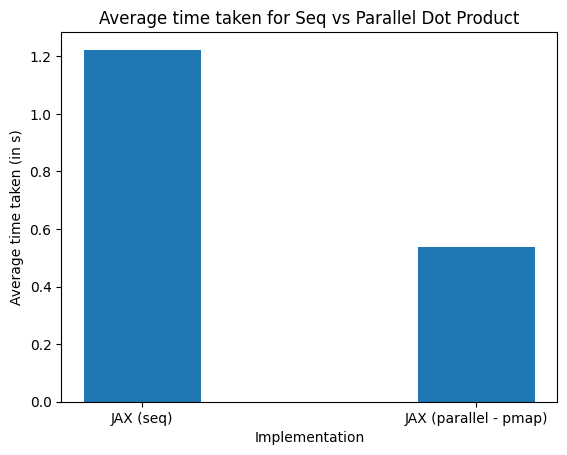

JAX (parallel - pmap) was 2.28 times faster than JAX (seq) !!!


In [40]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

# 📈 Model Training

So far we have only used core JAX for our development. This can be tedious, especially when dealing with larger models and when using more complicated optimization methods.

Luckily, JAX has higher-level neural network libraries such as Haiku, which make building models more convenient, and libraries like Optax, that make gradient processing and optimization more convenient. As well as that, we can easily use other frameworks, such as TensorFlow, to handle things like dataloaders.

In this section, we will briefly go through how to training a simple linear regression model using [Haiku](https://github.com/deepmind/dm-haiku), [Optax](https://github.com/deepmind/optax) and [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [41]:
%%capture
# @title Install Haiku and Optax. (Run Cell)
!pip install -U dm-haiku

In [42]:
from typing import NamedTuple, Tuple
import haiku as hk
import jax
from jax import numpy as jnp
import tensorflow as tf
import numpy as np
import optax
import functools

In [43]:
# @title Build our Dataset with TensorFlow Dataset


def make_dataset(size: int = 128, batch_size: int = 32, true_w: int = 2,
                 true_b: int = -1, noise: float = 0.5) -> tf.data.Iterator:


    # Generate true data from y = w*x + b + noise
    xs = np.random.normal(size=(size, 1))
    noise = 0.5 * np.random.normal(size=(size, 1))
    ys = xs * true_w + true_b + noise

    # Create a tensorflow dataset
    data = tf.data.Dataset.from_tensor_slices((xs, ys))
    data = data.batch(batch_size)
    data = data.repeat() # enable repeating for multiple epochs

    # Convert tf.Dataset to NumPy iterator, for better compatibility with JAX
    dataset =  iter(data.as_numpy_iterator())

    return dataset

In [45]:
# @title Data Parallel Learning
class TrainingState(NamedTuple):
    """Container for the training state."""
    params: hk.Params
    opt_state: optax.OptState
    step: jnp.DeviceArray

def model_fn(x: jnp.ndarray) -> jnp.ndarray:
    net = hk.Sequential([
        hk.Linear(output_size=1, name='linear')
    ])
    return net(x)

# Transforms the model function into a pair of pure functions using Haiku's init and apply functions.
model = hk.without_apply_rng(hk.transform(model_fn))

def loss_fn(params: hk.Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
    """Computes the least squares error of the model's
    predictions on x against y.
    """
    pred = model.apply(params, xs)
    return jnp.mean((pred - ys) ** 2)

@functools.partial(jax.pmap, axis_name='num_devices')
def update(state: TrainingState,
           xs: jnp.ndarray,
           ys: jnp.ndarray) -> Tuple[TrainingState, jnp.array]:
    """Performs one SGD update step on params using the given data."""

    # get the grads and the loss value back for tracking metrics
    loss, grads = jax.value_and_grad(loss_fn)(state.params, xs, ys)

    # Since we use pmap we Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='num_devices')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='num_devices')

    # Use optax to update the gradients.
    updates, new_opt_state = optimizer.update(grads, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    # Create a new, updated TrainingState to be used for the next step.
    return TrainingState(new_params, new_opt_state, state.step + 1), loss


In [46]:
# @title State Initialization

# Initialise parameters and replicate across devices.
data_iter = make_dataset()
init_params = model.init(jax.random.PRNGKey(123), next(data_iter)[0])
n_devices = jax.local_device_count()
devices = jax.local_devices()

# Initialize the optimizer and its state.
optimizer = optax.sgd(0.005)
opt_state = optimizer.init(init_params)

# Initialize training state
state = TrainingState(init_params, opt_state, jnp.array(0))
state = jax.device_put_sharded([state] * n_devices, devices)

/usr/local/lib/python3.10/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


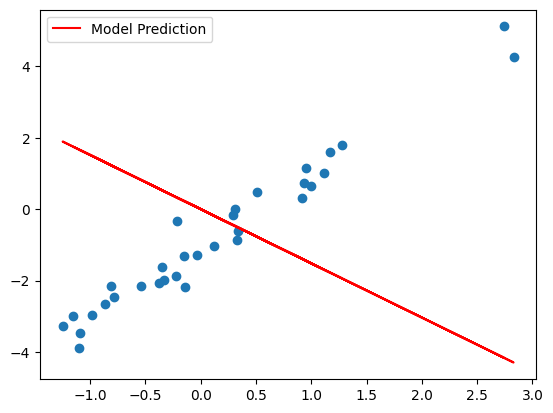

In [47]:
# @title Test out our untrained model
import matplotlib.pyplot as plt

# remember, our params are replicated across all devices, so we want to just
# take params from one of them.
params = jax.device_get(jax.tree_map(lambda x: x[0], state.params))
xs, ys = next(data_iter)

plt.scatter(xs, ys)
plt.plot(xs, params['linear']['w'] * xs + params['linear']['b'], c='red', label='Model Prediction')
plt.legend()
plt.show()

In [49]:
# @title Training Loop
def split(data: np.ndarray, n_devices: int) -> np.ndarray:
  """Splits the first axis of `data` evenly across the number of devices."""
  return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

# Actual training loop.
for i in range(1000):
    # Fetch next batch
    xs, ys = next(data_iter)

    # Reshape xs and ys for the pmapped `update()`.
    x_split = split(xs, n_devices)
    y_split = split(ys, n_devices)

    state, loss = update(state, x_split, y_split)

    if i % 100 == 0:
        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss.
        # So, we take the first element to print it.
        print(f"Step {i}, loss: {loss[0]:.3f}")

Step 0, loss: 0.173
Step 100, loss: 0.174
Step 200, loss: 0.174
Step 300, loss: 0.174
Step 400, loss: 0.174
Step 500, loss: 0.174
Step 600, loss: 0.174
Step 700, loss: 0.174
Step 800, loss: 0.174
Step 900, loss: 0.174


Trained model's parameters: {'linear': {'b': array([-0.9968871], dtype=float32), 'w': array([[2.061374]], dtype=float32)}}


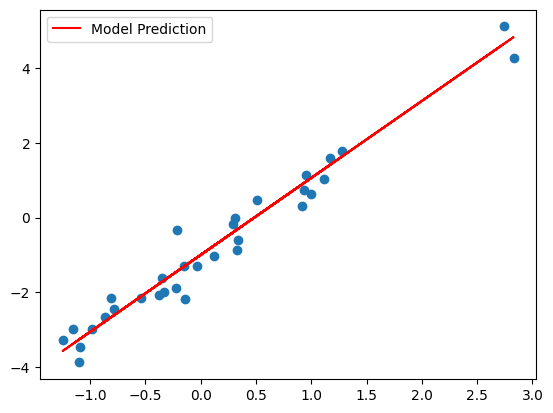

In [51]:
# @title Plot our trained model

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], state.params))

# Printing the trained model's parameters
print("Trained model's parameters:", params)

plt.scatter(xs, ys)
plt.plot(xs, params['linear']['w'] * xs + params['linear']['b'], c='red', label='Model Prediction')
plt.legend()
plt.show()

# 🔢 Coding Challenge!

Now that you have gone through all the key aspects of building a JAX ML model try and test yourself by building out a custom JAX to train on the MNIST dataset.

If you get stuck, refer back to the Linear Regression example above or check out some of the Further Reading in the section below.

In [ ]:
from typing import Iterator, NamedTuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds

NUM_CLASSES = 10  # MNIST has 10 classes (hand-written digits).

class Batch(NamedTuple):
    image: np.ndarray  # [B, H, W, 1]
    label: np.ndarray  # [B]

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

# MNIST Dataset
def load_dataset(
    split: str,
    *,
    shuffle: bool,
    batch_size: int,
):
    """Loads the MNIST dataset into a handy TensorFlow Dataset."""
    ds, ds_info = tfds.load("mnist:3.*.*", split=split, with_info=True)
    ds.cache()
    if shuffle:
        ds = ds.shuffle(ds_info.splits[split].num_examples, seed=0)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x: Batch(**x))
    return iter(tfds.as_numpy(ds))


# Model
def net_fn(images: jax.Array) -> jax.Array:
    """Create a simple network that is able to train on the MNIST dataset."""
    # TODO

network = # TODO
optimiser = # TODO

def loss_fn(params: hk.Params, batch: Batch) -> jax.Array:
    """Cross-entropy classification loss, regularised by L2 weight decay."""
    # TODO

@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Learning rule (stochastic gradient descent)."""
    # TODO

# Make datasets.
train_dataset = load_dataset("train", shuffle=True, batch_size=1_000)

# Initialise network and optimiser; note we draw an input to get shapes.
state = #TODO

# Training & evaluation loop.
for step in range(2000):

    # Do SGD on a batch of training examples.
    state, loss = update(state, next(train_dataset))

    if step % 100 == 0:
        print(f"Step {step}, loss: {loss:.3f}")

# 📚Further Reading

This is just a taste of all you can do using JAX. Here are some of our favourite resources for becoming a JAX pro. For a more in depth version of this workshop, make sure to checkout [Intro To ML Using JAX](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Introduction_to_ML_using_JAX.ipynb) from Deep Learning Indaba 2022!


* [Jax Documentation](https://jax.readthedocs.io/en/latest/)
* [Intro To ML Using JAX](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/Introduction_to_ML_using_JAX.ipynb)
* [Awesome Jax: Currated List Of JAX Resources](https://github.com/n2cholas/awesome-jax)
* [JAX Zero To Hero](https://www.youtube.com/watch?v=SstuvS-tVc0&list=PLBoQnSflObckOARbMK9Lt98Id0AKcZurq)
* [Why You Should (Or Shouldn't) Be Using JAX - Assembly AI](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2023/#:~:text=If%20most%20of%20your%20work,to%20use%20JAX%20going%20forward.)